In [1]:
from environments.utils import create_data
import matplotlib.pyplot as plt
from typing import Tuple, List
import torch
from environments.environment import SP500TradingEnv
import pandas as pd
import numpy as np

In [2]:
forex_data = pd.read_csv('C:/Users/Maciej/PycharmProjects/FinDL/data/EURUSD_1m_ta_tf.csv', index_col=0, parse_dates=True, sep='\t')

In [8]:
# show columns with missing values
forex_data.isnull().sum()

open           0
high           0
low            0
close          0
volume         0
              ..
cos_yearday    0
sin_hour       0
cos_hour       0
sin_minute     0
cos_minute     0
Length: 71, dtype: int64

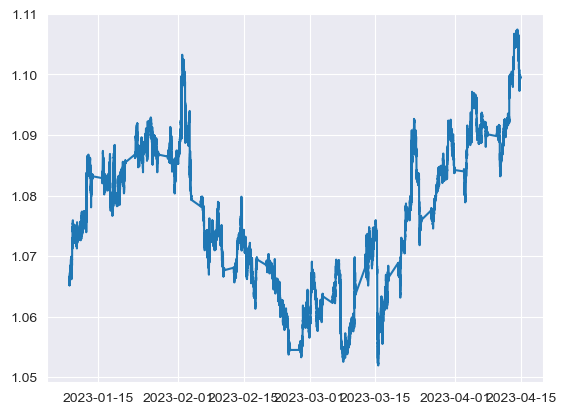

In [3]:
# plot open
plt.plot(forex_data['open'])
plt.show()

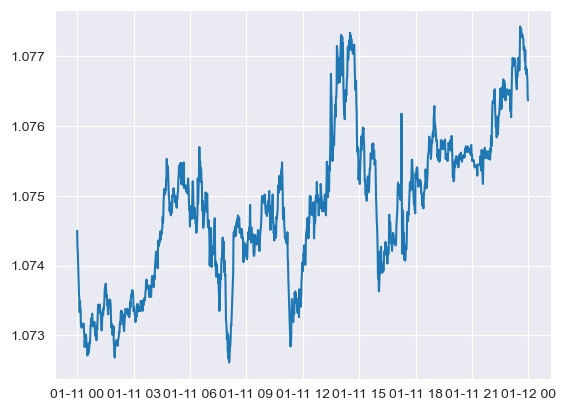

In [12]:
# forex data from one day 2023-01-10
forex_data_one_day = forex_data.loc['2023-01-11']

# plot open
plt.plot(forex_data_one_day['open'])
plt.show()

In [13]:
# show which columns have missing values
forex_data_one_day.isnull().sum()

open           0
high           0
low            0
close          0
volume         0
              ..
cos_yearday    0
sin_hour       0
cos_hour       0
sin_minute     0
cos_minute     0
Length: 71, dtype: int64

In [14]:
# fill missing values with previous values
forex_data_one_day = forex_data_one_day.fillna(method='ffill')

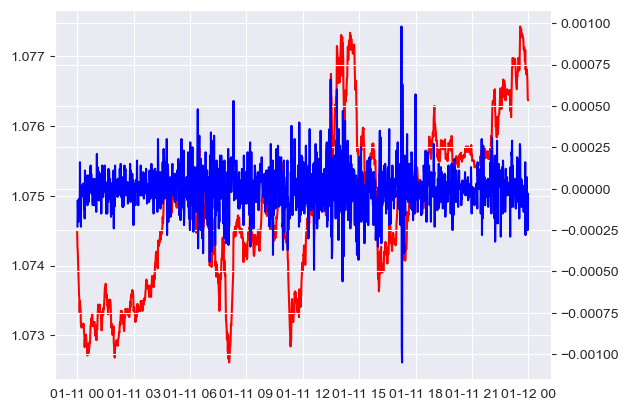

In [17]:
# calculate derivative of each column where it makes sense
forex_data_one_day_pct_change = forex_data_one_day.diff()

# plot open and percentage change of open on one plot with different scales
fig, ax1 = plt.subplots()
ax1.plot(forex_data_one_day['open'], color='red')
ax2 = ax1.twinx()
ax2.plot(forex_data_one_day_pct_change['open'], color='blue')
plt.show()

In [18]:
# forex data from one day 2023-01-10 and 3pm to 4pm
forex_data_one_hour = forex_data_one_day.loc['2023-01-11 15:00:00':'2023-01-11 16:00:00']

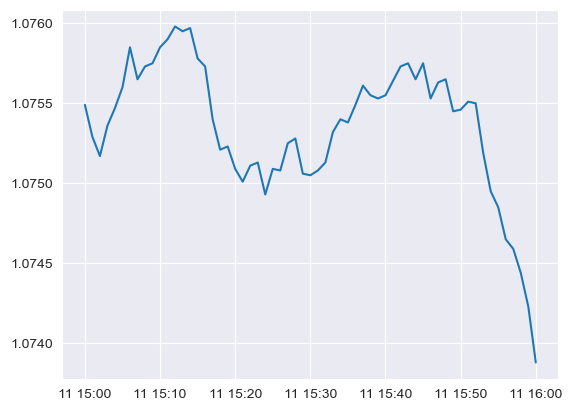

In [19]:
# plot open
plt.plot(forex_data_one_hour['open'])
plt.show()

In [20]:
# calculate derivative of each column where it makes sense
forex_data_one_hour_pct_change = forex_data_one_hour.diff()

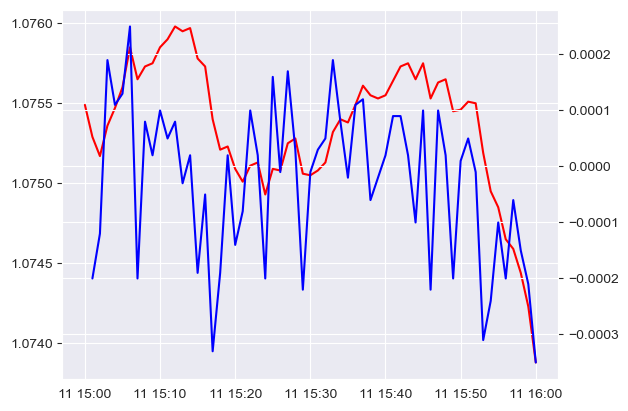

In [21]:
# plot open and percentage change of open on one plot with different scales
fig, ax1 = plt.subplots()
ax1.plot(forex_data_one_hour['open'], color='red')
ax2 = ax1.twinx()
ax2.plot(forex_data_one_hour_pct_change['open'], color='blue')
plt.show()

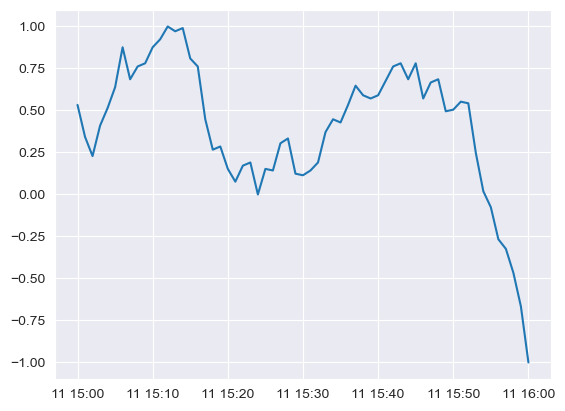

In [26]:
# create a new series which normalizes the open data to -1 to 1
forex_data_one_hour_normalized = (forex_data_one_hour['open'] - forex_data_one_hour['open'].min()) / (forex_data_one_hour['open'].max() - forex_data_one_hour['open'].min()) * 2 -1
# plot scaled open
plt.plot(forex_data_one_hour_normalized)
plt.show()

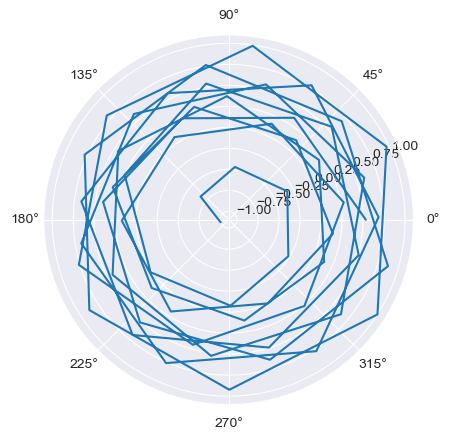

In [31]:
# create polar plot of normalized open
scaled_one_hour_data = forex_data_one_hour_normalized.values.tolist()
plt.polar(scaled_one_hour_data)
plt.show()

In [36]:
# create gramian angular field from normalized open
from pyts.image import GramianAngularField
gaf = GramianAngularField(image_size=len(scaled_one_hour_data), method='summation')

In [37]:
# create gaf from normalized open
gaf_one_hour_data = gaf.fit_transform(np.array(scaled_one_hour_data).reshape(1, -1))

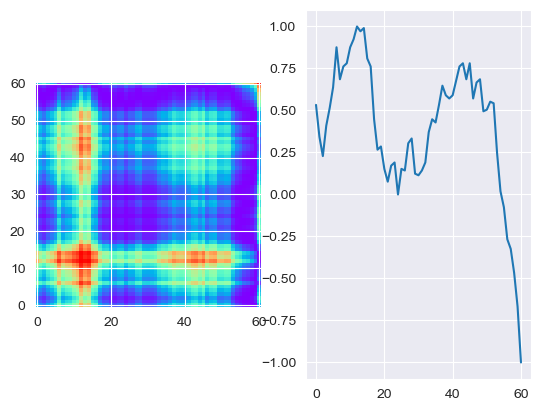

In [38]:
# plot gaf and normalized open side by side
fig, axs = plt.subplots(1, 2)
axs[0].imshow(gaf_one_hour_data[0], cmap='rainbow', origin='lower')
axs[1].plot(scaled_one_hour_data)
plt.show()

In [40]:
# get derivative of normalized open
scaled_one_hour_data_pct_change = forex_data_one_hour_normalized.diff()

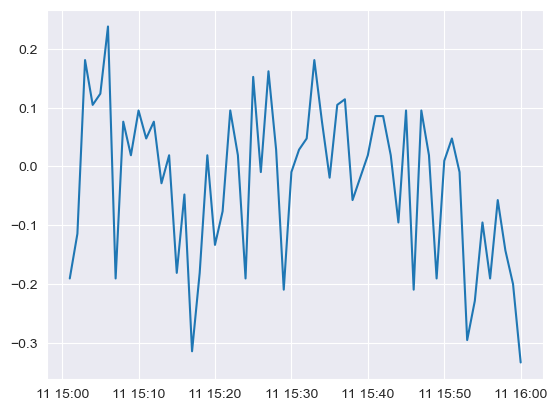

In [42]:
# plot derivative of normalized open
plt.plot(scaled_one_hour_data_pct_change)
plt.show()

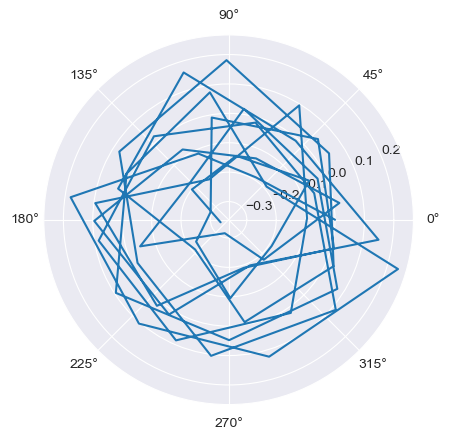

In [46]:
# plot polar plot of derivative of normalized open
scaled_one_hour_data_pct_change_values = scaled_one_hour_data_pct_change.values.tolist()
# remove nan by replacing with 0
scaled_one_hour_data_pct_change_values = [0 if np.isnan(x) else x for x in scaled_one_hour_data_pct_change_values]
plt.polar(scaled_one_hour_data_pct_change_values)
plt.show()

In [47]:
# create gaf from derivative of normalized open
gaf_one_hour_data_pct_change = gaf.fit_transform(np.array(scaled_one_hour_data_pct_change_values).reshape(1, -1))

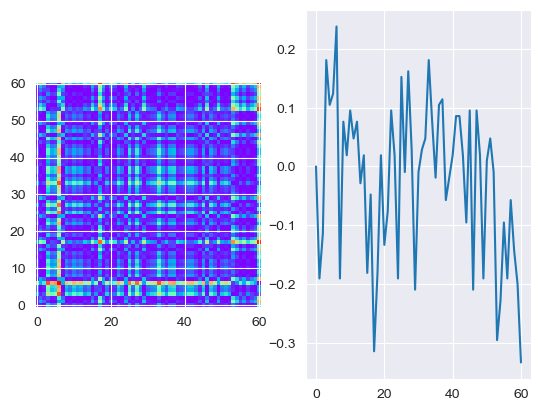

In [48]:
# plot gaf and derivative of normalized open side by side
fig, axs = plt.subplots(1, 2)
axs[0].imshow(gaf_one_hour_data_pct_change[0], cmap='rainbow', origin='lower')
axs[1].plot(scaled_one_hour_data_pct_change_values)
plt.show()

#### Experiments with scaling the data

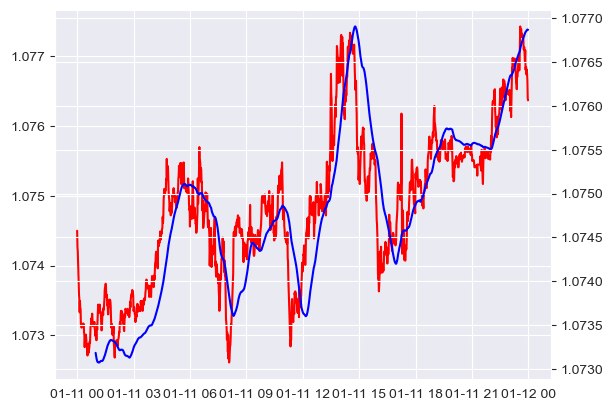

In [58]:
# let's calculate moving average on one day data
forex_open_moving_average = forex_data_one_day['open'].rolling(60).mean()
# let's calculate moving standard deviation on one day data
forex_open_moving_std = forex_data_one_day['open'].rolling(60).std()
# plot open and moving average and moving standard deviation on one plot
fig, ax1 = plt.subplots()
ax1.plot(forex_data_one_day['open'], color='red')
ax2 = ax1.twinx()
ax2.plot(forex_open_moving_average, color='blue')
plt.show()

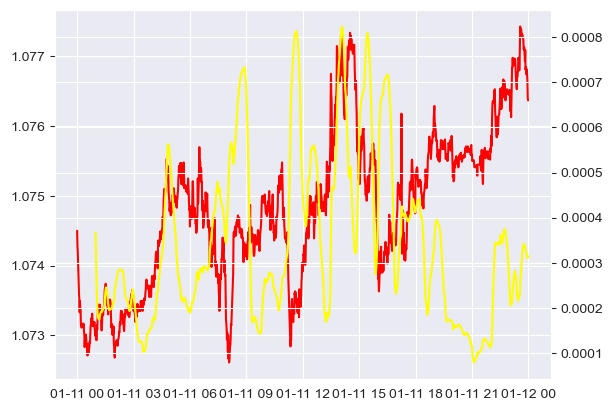

In [60]:
# plot open and moving average and moving standard deviation on one plot
fig, ax1 = plt.subplots()
ax1.plot(forex_data_one_day['open'], color='red')
ax2 = ax1.twinx()
ax2.plot(forex_open_moving_std, color='yellow')
plt.show()

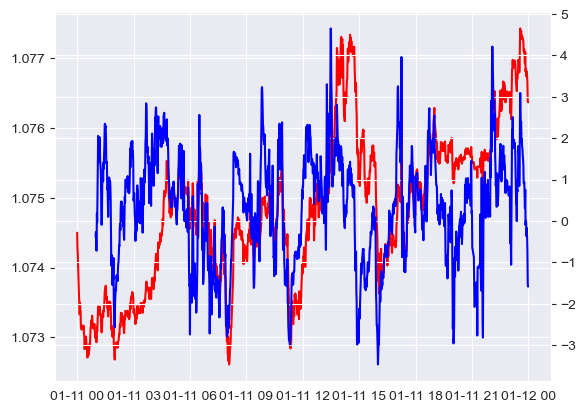

In [61]:
# let's scale the data based on the moving average and moving standard deviation
forex_data_one_day_scaled = (forex_data_one_day['open'] - forex_open_moving_average) / forex_open_moving_std
# plot open and scaled open on one plot
fig, ax1 = plt.subplots()
ax1.plot(forex_data_one_day['open'], color='red')
ax2 = ax1.twinx()
ax2.plot(forex_data_one_day_scaled, color='blue')
plt.show()

In [67]:
# let's create a function that scales the data based on the moving average and moving standard deviation
from tqdm import tqdm
def moving_average_scaling(data: pd.DataFrame, window_size: int) -> pd.DataFrame:
    """
    This function scales the data based on the moving average and moving standard deviation
    :param data: data to be scaled
    :param window_size: size of the window
    :return: scaled data
    """
    # create a copy of the data
    data_scaled = data.copy()
    # iterate over each column
    for column in tqdm(data_scaled.columns):
        # calculate moving average
        moving_average = data_scaled[column].rolling(window_size).mean().bfill()
        # print if moving average contains nan
        if moving_average.isnull().values.any():
            print(f"Moving average contains nan values for column {column}")
        # calculate moving standard deviation
        moving_std = data_scaled[column].rolling(window_size).std().bfill()
        # print if moving standard deviation contains nan
        if moving_std.isnull().values.any():
            print(f"Moving standard deviation contains nan values for column {column}")
        # scale the data
        data_scaled[column] = (data_scaled[column] - moving_average) / moving_std
    return data_scaled

In [75]:
# scale the data
forex_data_scaled = moving_average_scaling(forex_data, 180)

 30%|██▉       | 21/71 [00:00<00:00, 64.29it/s]

Moving average contains nan values for column BOP
Moving standard deviation contains nan values for column BOP
Moving average contains nan values for column FRAMA


 54%|█████▎    | 38/71 [00:00<00:00, 73.89it/s]

Moving standard deviation contains nan values for column FRAMA
Moving average contains nan values for column KAMA
Moving standard deviation contains nan values for column KAMA


100%|██████████| 71/71 [00:00<00:00, 88.86it/s] 


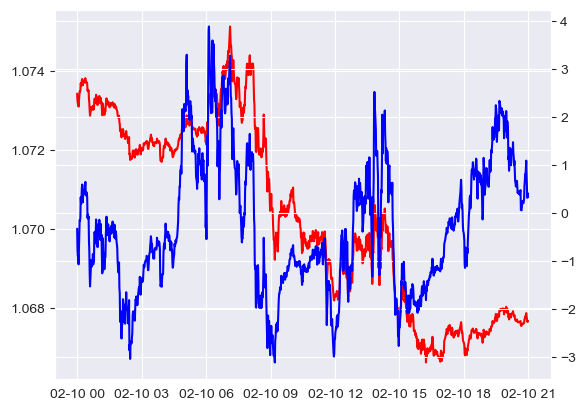

In [76]:
# plot open and scaled open from one day 2023-02-10 on one plot
fig, ax1 = plt.subplots()
# cut one day data
forex_data_2023_02_10 = forex_data.loc['2023-02-10']
forex_data_scaled_2023_02_10 = forex_data_scaled.loc['2023-02-10']
ax1.plot(forex_data_2023_02_10['open'], color='red')
ax2 = ax1.twinx()
ax2.plot(forex_data_scaled_2023_02_10['open'], color='blue')
plt.show()

In [98]:
# let's implement scaling of dataframe that is based on mean and standard deviation in certain window and also the mean is weighted based
import math
def get_weights(win_size=6 * 30):
    sigma = win_size/5
    value_at_one = 50
    arr = np.array([max(int(value_at_one*math.exp(-(i**2)/(2*sigma**2))),1) for i in range(win_size)][::-1])
    arr = arr/arr.sum()
    return arr

def moving_average_exponential_scaling(data: pd.DataFrame, window_size: int) -> pd.DataFrame:
    """
    This function scales the data based on the moving average and moving standard deviation
    :param data: data to be scaled
    :param window_size: size of the window
    :return: scaled data
    """
    # get weights for the window
    weights = get_weights(window_size)
    # create a copy of the data
    data_scaled = data.copy()
    # iterate over each column
    for column in tqdm(data_scaled.columns):
        # calculate exponential moving average
        moving_average = data_scaled[column].rolling(window_size).apply(lambda x: np.average(x, weights=weights)).bfill()
        # print if moving average contains nan
        if moving_average.isnull().values.any():
            print(f"Moving average contains nan values for column {column}")
        # calculate exponential moving standard deviation with weights based on the window
        moving_std = data_scaled[column].rolling(window_size).apply(lambda x: np.sqrt(np.average((x - np.average(x, weights=weights))**2, weights=weights))).bfill()
        # print if moving standard deviation contains nan
        if moving_std.isnull().values.any():
            print(f"Moving standard deviation contains nan values for column {column}")
        # scale the data
        data_scaled[column] = (data_scaled[column] - moving_average) / moving_std
    return data_scaled

In [101]:
# scale the data using exponential window
forex_data_exponential_scaled = moving_average_exponential_scaling(forex_data[['open', 'close']], 1440)

100%|██████████| 2/2 [00:59<00:00, 29.69s/it]


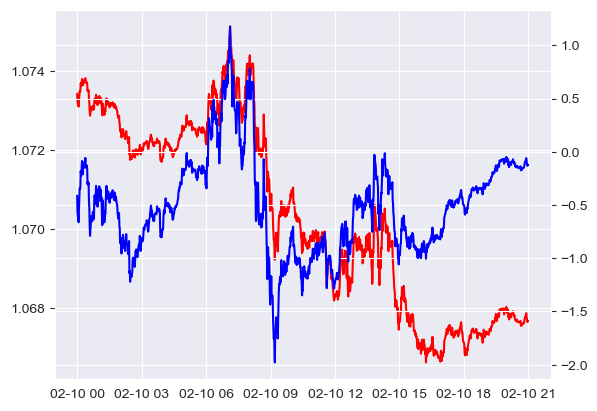

In [102]:
# plot open and exponentialy scaled open from one day 2023-02-10 on one plot
fig, ax1 = plt.subplots()
# cut one day data
forex_data_2023_02_10 = forex_data.loc['2023-02-10']
forex_data_exponential_scaled_2023_02_10 = forex_data_exponential_scaled.loc['2023-02-10']
ax1.plot(forex_data_2023_02_10['open'], color='red')
ax2 = ax1.twinx()
ax2.plot(forex_data_exponential_scaled_2023_02_10['open'], color='blue')
plt.show()

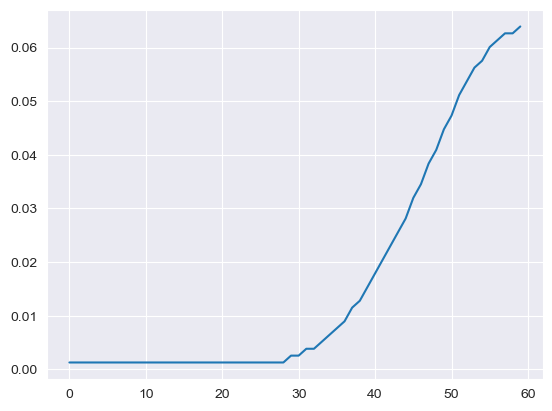

In [95]:
# show weights
plt.plot(get_weights(60))

In [96]:
# let's calculate exponential window scaling with different window sizes
# 30
forex_data_exponential_scaled_30 = moving_average_exponential_scaling(forex_data[['open', 'close']], 30)

100%|██████████| 2/2 [01:02<00:00, 31.00s/it]


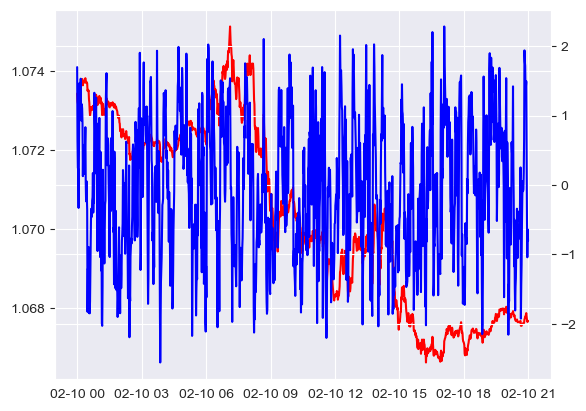

In [97]:
# plot open and exponentialy scaled open from one day 2023-02-10 on one plot
fig, ax1 = plt.subplots()
# cut one day data that is scaled with window size 30
forex_data_exponential_scaled_30_2023_02_10 = forex_data_exponential_scaled_30.loc['2023-02-10']
ax1.plot(forex_data_2023_02_10['open'], color='red')
ax2 = ax1.twinx()
ax2.plot(forex_data_exponential_scaled_30_2023_02_10['open'], color='blue')
plt.show()

In [54]:
# scale the data
forex_data_one_day_scaled = exponential_window_scaling(forex_data_one_day, 60, 60)
# plot open and scaled open on one plot
fig, ax1 = plt.subplots()
ax1.plot(forex_data_one_day['open'], color='red')
ax2 = ax1.twinx()
ax2.plot(forex_data_one_day_scaled['open'], color='blue')
plt.show()

  0%|          | 0/71 [00:00<?, ?it/s]

nan
nan
1436
4.035388943837236e-11
nan
nan
1435
4.1032090236644254e-11
nan
nan
1434
4.172168910160028e-11
nan
nan
1433
4.24228775929146e-11
nan
nan
1432
4.313585048967699e-11
nan
nan
1431
4.386080584449881e-11
nan
nan
1430
4.459794503852922e-11
nan
nan
1429
4.534747283739501e-11
nan
nan
1428
4.610959744808222e-11
nan
nan
1427
4.6884530576772143e-11
nan
nan
1426
4.767248748765026e-11
nan
nan
1425
4.8473687062702556e-11
nan
nan
1424
4.9288351862518515e-11
nan
nan
1423
5.011670818811441e-11
nan
nan
1422
5.0958986143795644e-11
nan
nan
1421
5.181541970107712e-11
nan
nan
1420
5.2686246763676146e-11
nan
nan
1419
5.35717092335987e-11
nan
nan
1418
5.4472053078335215e-11
nan
nan
1417
5.538752839918761e-11
nan
nan
1416
5.631838950074272e-11
nan
nan
1415
5.726489496151448e-11
nan
nan
1414
5.822730770577217e-11
nan
nan
1413
5.92058950765778e-11
nan
nan
1412
6.020092891004902e-11
nan
nan
1411
6.121268561087126e-11
nan
nan
1410
6.224144622907783e-11
nan
nan
1409
6.328749653812236e-11
nan
nan
1408
6.4

C:\Users\Maciej\AppData\Local\Temp\ipykernel_18244\3026902814.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_scaled[column].iloc[i] = (data_scaled[column].iloc[i] - mean) / std * weight


nan
nan
1084
1.4247752433068722e-08
nan
nan
1083
1.4487204867720514e-08
nan
nan
1082
1.473068161910086e-08
nan
nan
1081
1.497825032120633e-08
nan
nan
1080
1.522997974471263e-08
nan
nan
1079
1.5485939816078318e-08
nan
nan
1078
1.5746201636969122e-08
nan
nan
1077
1.6010837504008696e-08
nan
nan
1076
1.6279920928861788e-08
nan
nan
1075
1.655352665865443e-08
nan
nan
1074
1.6831730696737596e-08
nan
nan
1073
1.7114610323799523e-08
nan
nan
1072
1.7402244119333394e-08
nan
nan
1071
1.7694711983465263e-08
nan
nan
1070
1.7992095159149157e-08
nan
nan
1069
1.8294476254734847e-08
nan
nan
1068
1.860193926691551e-08
nan
nan
1067
1.8914569604060437e-08
nan
nan
1066
1.9232454109940256e-08
nan
nan
1065
1.9555681087850496e-08
nan
nan
1064
1.9884340325141247e-08
nan
nan
1063
2.0218523118158476e-08
nan
nan
1062
2.0558322297604485e-08
nan
nan
1061
2.090383225432524e-08
nan
nan
1060
2.125514896553039e-08
nan
nan
1059
2.1612370021454343e-08
nan
nan
1058
2.1975594652465007e-08
nan
nan
1057
2.234492375662886e-08


  1%|▏         | 1/71 [00:00<00:54,  1.29it/s]

nan
nan
3
0.951229424500714
nan
nan
2
0.9672161004820059
nan
nan
1
0.9834714538216175
nan
nan
1436
4.035388943837236e-11
nan
nan
1435
4.1032090236644254e-11
nan
nan
1434
4.172168910160028e-11
nan
nan
1433
4.24228775929146e-11
nan
nan
1432
4.313585048967699e-11
nan
nan
1431
4.386080584449881e-11
nan
nan
1430
4.459794503852922e-11
nan
nan
1429
4.534747283739501e-11
nan
nan
1428
4.610959744808222e-11
nan
nan
1427
4.6884530576772143e-11
nan
nan
1426
4.767248748765026e-11
nan
nan
1425
4.8473687062702556e-11
nan
nan
1424
4.9288351862518515e-11
nan
nan
1423
5.011670818811441e-11
nan
nan
1422
5.0958986143795644e-11
nan
nan
1421
5.181541970107712e-11
nan
nan
1420
5.2686246763676146e-11
nan
nan
1419
5.35717092335987e-11
nan
nan
1418
5.4472053078335215e-11
nan
nan
1417
5.538752839918761e-11
nan
nan
1416
5.631838950074272e-11
nan
nan
1415
5.726489496151448e-11
nan
nan
1414
5.822730770577217e-11
nan
nan
1413
5.92058950765778e-11
nan
nan
1412
6.020092891004902e-11
nan
nan
1411
6.121268561087126e-11


  3%|▎         | 2/71 [00:01<00:52,  1.33it/s]

nan
nan
363
0.002357862006490233
nan
nan
362
0.0023974890143765195
nan
nan
361
0.0024377820068495625
nan
nan
360
0.0024787521766663585
nan
nan
359
0.002520410904693077
nan
nan
358
0.002562769763066483
nan
nan
357
0.0026058405184084983
nan
nan
356
0.002649635135094777
nan
nan
355
0.0026941657785782246
nan
nan
354
0.0027394448187683684
nan
nan
353
0.0027854848334675202
nan
nan
352
0.002832298611864697
nan
nan
351
0.002879899158088243
nan
nan
350
0.0029282996948181888
nan
nan
349
0.00297751366695929
nan
nan
348
0.0030275547453758153
nan
nan
347
0.0030784368306890934
nan
nan
346
0.003130174057138888
nan
nan
345
0.003182780796509667
nan
nan
344
0.003236271662122855
nan
nan
343
0.003290661512896186
nan
nan
342
0.003345965457471272
nan
nan
341
0.003402198858410551
nan
nan
340
0.0034593773364647584
nan
nan
339
0.0035175167749121284
nan
nan
338
0.0035766333239705167
nan
nan
337
0.003636743405283679
nan
nan
336
0.003697863716482932
nan
nan
335
0.0037600112358255108
nan
nan
334
0.0038232032269108

  4%|▍         | 3/71 [00:02<00:50,  1.35it/s]

nan
nan
1436
4.035388943837236e-11
nan
nan
1435
4.1032090236644254e-11
nan
nan
1434
4.172168910160028e-11
nan
nan
1433
4.24228775929146e-11
nan
nan
1432
4.313585048967699e-11
nan
nan
1431
4.386080584449881e-11
nan
nan
1430
4.459794503852922e-11
nan
nan
1429
4.534747283739501e-11
nan
nan
1428
4.610959744808222e-11
nan
nan
1427
4.6884530576772143e-11
nan
nan
1426
4.767248748765026e-11
nan
nan
1425
4.8473687062702556e-11
nan
nan
1424
4.9288351862518515e-11
nan
nan
1423
5.011670818811441e-11
nan
nan
1422
5.0958986143795644e-11
nan
nan
1421
5.181541970107712e-11
nan
nan
1420
5.2686246763676146e-11
nan
nan
1419
5.35717092335987e-11
nan
nan
1418
5.4472053078335215e-11
nan
nan
1417
5.538752839918761e-11
nan
nan
1416
5.631838950074272e-11
nan
nan
1415
5.726489496151448e-11
nan
nan
1414
5.822730770577217e-11
nan
nan
1413
5.92058950765778e-11
nan
nan
1412
6.020092891004902e-11
nan
nan
1411
6.121268561087126e-11
nan
nan
1410
6.224144622907783e-11
nan
nan
1409
6.328749653812236e-11
nan
nan
1408
6.4

  6%|▌         | 4/71 [00:02<00:48,  1.37it/s]

nan
nan
205
0.03282165832666321
nan
nan
204
0.03337326996032608
nan
nan
203
0.0339341521613492
nan
nan
202
0.034504460733950484
nan
nan
201
0.035084354100845025
nan
nan
200
0.035673993347252395
nan
nan
199
0.03627354226564359
nan
nan
198
0.036883167401240015
nan
nan
197
0.03750303809827702
nan
nan
196
0.038133326547045196
nan
nan
195
0.03877420783172201
nan
nan
194
0.03942585997900747
nan
nan
193
0.04008846400757714
nan
nan
192
0.04076220397836621
nan
nan
191
0.04144726704569881
nan
nan
190
0.042143843509276406
nan
nan
189
0.04285212686704019
nan
nan
188
0.04357231386892163
nan
nan
187
0.044304604571496584
nan
nan
186
0.0450492023935578
nan
nan
185
0.04580631417262147
nan
nan
184
0.046576150222383414
nan
nan
183
0.04735892439114093
nan
nan
182
0.0481548541211964
nan
nan
181
0.04896416050925942
nan
nan
180
0.049787068367863944
nan
nan
179
0.050623806287817624
nan
nan
178
0.05147460670170076
nan
nan
177
0.05233970594843238
nan
nan
176
0.05321934433892151
nan
nan
175
0.05411376622282161
n

  7%|▋         | 5/71 [00:03<00:42,  1.57it/s]

nan
nan
35
0.5580351457700471
nan
nan
34
0.5674136687970038
nan
nan
33
0.5769498103804866
nan
nan
32
0.5866462195100318
nan
nan
31
0.5965055896949684
nan
nan
30
0.6065306597126334
nan
nan
29
0.6167242143691608
nan
nan
28
0.6270890852730561
nan
nan
27
0.6376281516217733
nan
nan
26
0.6483443410015097
nan
nan
25
0.6592406302004438
nan
nan
24
0.6703200460356393
nan
nan
23
0.6815856661938479
nan
nan
22
0.6930406200864415
nan
nan
21
0.7046880897187134
nan
nan
20
0.7165313105737893
nan
nan
19
0.728573572511393
nan
nan
18
0.7408182206817179
nan
nan
17
0.7532686564546568
nan
nan
16
0.7659283383646487
nan
nan
15
0.7788007830714049
nan
nan
14
0.7918895663367816
nan
nan
13
0.8051983240180706
nan
nan
12
0.8187307530779818
nan
nan
11
0.8324906126116027
nan
nan
10
0.8464817248906141
nan
nan
9
0.8607079764250578
nan
nan
8
0.8751733190429475
nan
nan
7
0.8898817709880238
nan
nan
6
0.9048374180359595
nan
nan
5
0.9200444146293233
nan
nan
4
0.9355069850316178
nan
nan
3
0.951229424500714
nan
nan
2
0.9672161

  8%|▊         | 6/71 [00:04<00:43,  1.50it/s]

nan
nan
220
0.025561533206507402
nan
nan
219
0.025991128778755347
nan
nan
218
0.026427944276122963
nan
nan
217
0.026872101039057177
nan
nan
216
0.02732372244729256
nan
nan
215
0.02778293395412425
nan
nan
214
0.028249863121256928
nan
nan
213
0.028724639654239433
nan
nan
212
0.029207395438494873
nan
nan
211
0.02969826457595639
nan
nan
210
0.0301973834223185
nan
nan
209
0.030704890624914584
nan
nan
208
0.031220927161230903
nan
nan
207
0.03174563637806794
nan
nan
206
0.032279164031359865
nan
nan
205
0.03282165832666321
nan
nan
204
0.03337326996032608
nan
nan
203
0.0339341521613492
nan
nan
202
0.034504460733950484
nan
nan
201
0.035084354100845025
nan
nan
200
0.035673993347252395
nan
nan
199
0.03627354226564359
nan
nan
198
0.036883167401240015
nan
nan
197
0.03750303809827702
nan
nan
196
0.038133326547045196
nan
nan
195
0.03877420783172201
nan
nan
194
0.03942585997900747
nan
nan
193
0.04008846400757714
nan
nan
192
0.04076220397836621
nan
nan
191
0.04144726704569881
nan
nan
190
0.0421438435092

  8%|▊         | 6/71 [00:04<00:49,  1.32it/s]

nan
nan
1035
3.2241867372567335e-08
nan
nan
1034
3.278373484790068e-08
nan
nan
1033
3.333470912705016e-08
nan
nan
1032
3.389494326196924e-08
nan
nan
1031
3.446459287685344e-08
nan
nan
1030
3.504381621136978e-08
nan
nan
1029
3.563277416461356e-08
nan
nan
1028
3.623163033980305e-08
nan
nan
1027
3.6840551089726615e-08
nan
nan
1026
3.745970556295245e-08
nan
nan
1025
3.808926575081559e-08
nan
nan
1024
3.8729406535193856e-08
nan
nan
1023
3.93803057370881e-08
nan
nan
1022
4.004214416601753e-08
nan
nan
1021
4.071510567024602e-08
nan
nan
1020
4.139937718785167e-08
nan
nan
1019
4.20951487986561e-08
nan
nan
1018
4.280261377702524e-08
nan
nan
1017
4.352196864555741e-08
nan
nan
1016
4.4253413229675097e-08
nan
nan
1015
4.4997150713132706e-08
nan
nan
1014
4.5753387694458114e-08
nan
nan
1013
4.652233424434182e-08
nan
nan
1012
4.730420396399225e-08
nan
nan
1011
4.809921404447013e-08
nan
nan
1010
4.890758532702111e-08
nan
nan
1009
4.972954236442123e-08
nan
nan
1008
5.05653134833552e-08
nan
nan
1007
5.14

KeyboardInterrupt: 